<a href="https://colab.research.google.com/github/WillDela/Python_Practice/blob/main/CAI4203_Garbage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import numpy as np
from PIL import Image
import os

# Set random seed for reproducibility
np.random.seed(42)

# Download latest version
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
path = path + '/garbage_classification'
print("Path to dataset files:", path)

NUM_CLASSES = len(os.listdir(path))
print(f"Number of classes: {NUM_CLASSES}")

class_names = sorted(os.listdir(path))
print(f"Classes: {class_names}")

# Set image size slightly larger for better results
img_size = 96

Path to dataset files: /kaggle/input/garbage-classification/garbage_classification
Number of classes: 12
Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [2]:
img_size = 96

images = []
labels = []
total_processed = 0

for class_folder in os.listdir(path):
    class_path = os.path.join(path, class_folder)

    if not os.path.isdir(class_path):
        continue

    print(f"Loading {class_folder}...")
    class_count = 0

    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)

        if not os.path.isfile(img_path) or not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        try:  # Error handling for corrupted images
            img = Image.open(img_path)
            img = img.convert('RGB')
            img = img.resize((img_size, img_size), Image.Resampling.LANCZOS)  # quality resizing
            img_array = np.array(img, dtype=np.float32)  # Memory efficient

            images.append(img_array)
            labels.append(class_folder)
            class_count += 1
            total_processed += 1

        except Exception as e:
            print(f"  Skipped corrupted image: {img_file}")
            continue

    print(f"  Loaded {class_count} images")

print(f"Total images loaded: {total_processed}")

images = np.array(images, dtype=np.float32)
images = images / 255.0
labels = np.array(labels)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Memory usage: {images.nbytes / (1024**2):.1f} MB")

Loading metal...
  Loaded 769 images
Loading white-glass...
  Loaded 775 images
Loading biological...
  Loaded 985 images
Loading paper...
  Loaded 1050 images
Loading brown-glass...
  Loaded 607 images
Loading battery...
  Loaded 945 images
Loading trash...
  Loaded 697 images
Loading cardboard...
  Loaded 891 images
Loading shoes...
  Loaded 1977 images
Loading clothes...
  Loaded 5325 images
Loading plastic...
  Loaded 865 images
Loading green-glass...
  Loaded 629 images
Total images loaded: 15515
Images shape: (15515, 96, 96, 3)
Labels shape: (15515,)
Memory usage: 1636.3 MB


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
labels_encoded = lb.fit_transform(labels)

print("Class names:", lb.classes_)
print("Class distribution:")
unique, counts = np.unique(labels_encoded, return_counts=True)
for name, count in zip(lb.classes_, counts):
    print(f"  {name}: {count} images")

# Split data with stratification to maintain class balance
# ensure each split has same proportion of each class
X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_encoded,
    test_size=0.3,
    random_state=42,
    stratify=labels_encoded  # This is the key improvement!
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,  # 0.5 of 0.3 = 0.15 total for test, 0.15 for val
    random_state=42,
    stratify=y_temp  # Keep balance in val/test split too
)

print(f"\nData splits:")
print(f"Training:   {X_train.shape} ({len(X_train)/len(images)*100:.1f}%)")
print(f"Validation: {X_val.shape} ({len(X_val)/len(images)*100:.1f}%)")
print(f"Test:       {X_test.shape} ({len(X_test)/len(images)*100:.1f}%)")

print(f"\nClass distribution in training set:")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for name, count in zip(lb.classes_, train_counts):
    print(f"  {name}: {count} images ({count/len(y_train)*100:.1f}%)")

Class names: ['battery' 'biological' 'brown-glass' 'cardboard' 'clothes' 'green-glass'
 'metal' 'paper' 'plastic' 'shoes' 'trash' 'white-glass']
Class distribution:
  battery: 945 images
  biological: 985 images
  brown-glass: 607 images
  cardboard: 891 images
  clothes: 5325 images
  green-glass: 629 images
  metal: 769 images
  paper: 1050 images
  plastic: 865 images
  shoes: 1977 images
  trash: 697 images
  white-glass: 775 images

Data splits:
Training:   (10860, 96, 96, 3) (70.0%)
Validation: (2327, 96, 96, 3) (15.0%)
Test:       (2328, 96, 96, 3) (15.0%)

Class distribution in training set:
  battery: 661 images (6.1%)
  biological: 689 images (6.3%)
  brown-glass: 425 images (3.9%)
  cardboard: 624 images (5.7%)
  clothes: 3727 images (34.3%)
  green-glass: 440 images (4.1%)
  metal: 538 images (5.0%)
  paper: 735 images (6.8%)
  plastic: 606 images (5.6%)
  shoes: 1384 images (12.7%)
  trash: 488 images (4.5%)
  white-glass: 543 images (5.0%)


In [4]:
import os
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [5]:
unique, counts = np.unique(y_train, return_counts=True)
class_weights = dict(zip(unique, max(counts) / counts))
print("Class weights:", class_weights)

def train_plot_test_cnn_model(model, optimizer='adam', epochs=25, batch_size=32):
    model.summary()

    # callbacks to prevent overfitting
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
    ]

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,  # Prevent overfitting
        class_weight=class_weights,  # Handle class imbalance
        shuffle=True
    )

    # Plot training accuracy vs validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot training loss vs validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Evaluate on test set
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Loss: {loss:.4f}")

    return history

Class weights: {np.int64(0): np.float64(5.638426626323752), np.int64(1): np.float64(5.409288824383164), np.int64(2): np.float64(8.769411764705882), np.int64(3): np.float64(5.972756410256411), np.int64(4): np.float64(1.0), np.int64(5): np.float64(8.470454545454546), np.int64(6): np.float64(6.9275092936802976), np.int64(7): np.float64(5.070748299319728), np.int64(8): np.float64(6.15016501650165), np.int64(9): np.float64(2.6929190751445087), np.int64(10): np.float64(7.637295081967213), np.int64(11): np.float64(6.863720073664825)}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,733,804 (37.13 MB)

 Trainable params: 9,732,332 (37.13 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - accuracy: 0.3724 - loss: 8.3121 - val_accuracy: 0.3777 - val_loss: 2.0427 - learning_rate: 0.0010
Epoch 2/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.5615 - loss: 5.6464 - val_accuracy: 0.5264 - val_loss: 1.4662 - learning_rate: 0.0010
Epoch 3/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6088 - loss: 4.9213 - val_accuracy: 0.5191 - val_loss: 1.5326 - learning_rate: 0.0010
Epoch 4/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.6538 - loss: 4.4389 - val_accuracy: 0.6755 - val_loss: 1.0095 - learning_rate: 0.0010
Epoch 5/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6972 - loss: 3.7891 - val_accuracy: 0.6760 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 6/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7339 - loss: 3.4589 - val_accuracy: 0.6872 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 7/25
340/340 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7462 - l

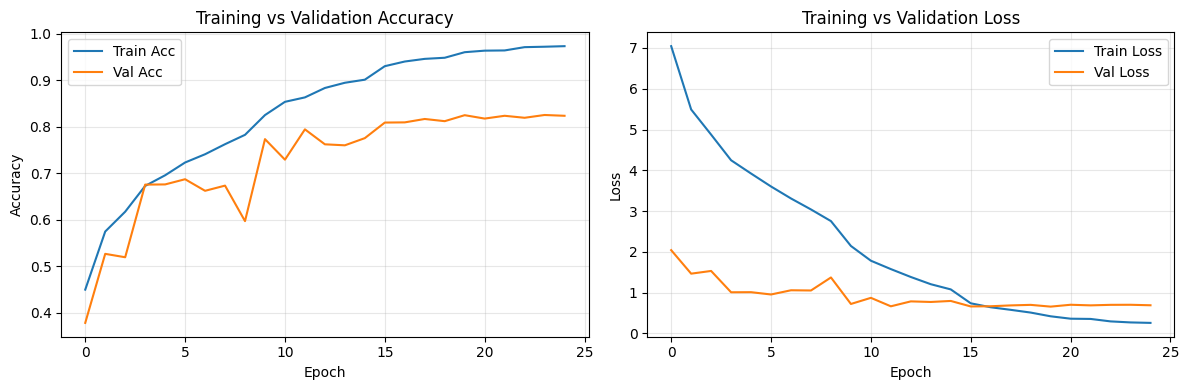

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8346 - loss: 0.6846
Test Accuracy: 0.8342
Test Loss: 0.6612


In [6]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),

    Conv2D(32, (3, 3), padding='same', activation='relu'),  # Start smaller
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Prevent overfitting

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Higher dropout before final layer
    Dense(NUM_CLASSES, activation='softmax')
])

history = train_plot_test_cnn_model(model)

Main Challenge: Overfitting

## Ethical Considerations
The dataset may not reflect all regional waste variations, potentially limiting generalizability. There is no personally identifiable information, so privacy risks are minimal. Misclassifications in real-world settings could lead to improper waste handling.

73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


<Figure size 1000x800 with 0 Axes>

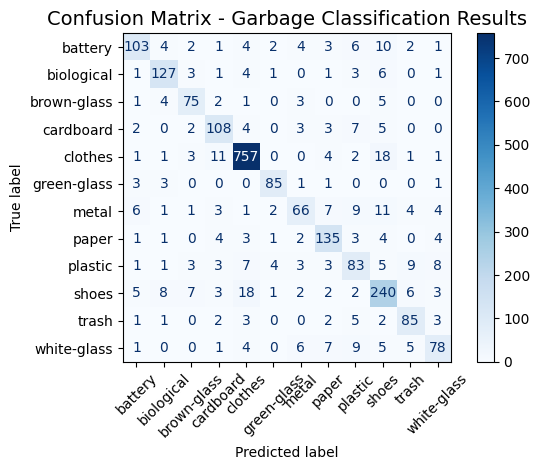

Classification Report:
              precision    recall  f1-score   support

     battery       0.82      0.73      0.77       142
  biological       0.84      0.86      0.85       148
 brown-glass       0.78      0.82      0.80        91
   cardboard       0.78      0.81      0.79       134
     clothes       0.94      0.95      0.94       799
 green-glass       0.89      0.90      0.89        94
       metal       0.73      0.57      0.64       115
       paper       0.80      0.85      0.83       158
     plastic       0.64      0.64      0.64       130
       shoes       0.77      0.81      0.79       297
       trash       0.76      0.82      0.79       104
 white-glass       0.75      0.67      0.71       116

    accuracy                           0.83      2328
   macro avg       0.79      0.79      0.79      2328
weighted avg       0.83      0.83      0.83      2328


Per-Class Accuracy:
------------------------------
battery: 0.725 (142 samples)
biological: 0.858 (148 sample

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Get predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Enhanced confusion matrix with better formatting
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_)
disp.plot(xticks_rotation=45, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Garbage Classification Results", fontsize=14)
plt.tight_layout()
plt.show()

# Add classification report for detailed metrics
print("Classification Report:")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=lb.classes_))

# Quick analysis of which classes perform best/worst
print("\nPer-Class Accuracy:")
print("-" * 30)
for i, class_name in enumerate(lb.classes_):
    class_mask = (y_test == i)
    if np.sum(class_mask) > 0:
        class_acc = np.sum((y_pred == y_test) & class_mask) / np.sum(class_mask)
        print(f"{class_name}: {class_acc:.3f} ({np.sum(class_mask)} samples)")

In [10]:
from sklearn.metrics import classification_report

print("DETAILED CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=lb.classes_))

print("\nMODEL PERFORMANCE SUMMARY")
print("-" * 30)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Overall Test Accuracy: {test_accuracy:.4f}")
print(f"Number of test samples: {len(y_test)}")
print(f"Number of waste categories: {len(lb.classes_)}")
print("\nKey metrics per class shown above: Precision, Recall, F1-Score")

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

     battery       0.82      0.73      0.77       142
  biological       0.84      0.86      0.85       148
 brown-glass       0.78      0.82      0.80        91
   cardboard       0.78      0.81      0.79       134
     clothes       0.94      0.95      0.94       799
 green-glass       0.89      0.90      0.89        94
       metal       0.73      0.57      0.64       115
       paper       0.80      0.85      0.83       158
     plastic       0.64      0.64      0.64       130
       shoes       0.77      0.81      0.79       297
       trash       0.76      0.82      0.79       104
 white-glass       0.75      0.67      0.71       116

    accuracy                           0.83      2328
   macro avg       0.79      0.79      0.79      2328
weighted avg       0.83      0.83      0.83      2328


MODEL PERFORMANCE SUMMARY
------------------------------
Overall Test Accuracy: 0.8342
Number of test

## Model Observations & Limitations
The model demonstrates clear evidence of overfitting, with training accuracy reaching nearly 100% while validation accuracy plateaus around 82%, indicating the model is memorizing training data rather than learning generalizable features. Several improvements were implemented to enhance evaluation reliability, including stratified train/test splits to ensure balanced representation across all waste categories, increased image resolution (96x96 vs. original 64x64) for better feature extraction, and comprehensive evaluation through detailed classification reports that provide per-class performance metrics. Enhanced data preprocessing with error handling prevents crashes from corrupted images and ensures more robust data loading.


Despite these improvements, significant limitations remain. The severe overfitting shown in training curves represents the primary challenge, with an 18% gap between training and validation accuracy indicating poor generalization to new data. Memory constraints limit the ability to use larger image sizes or more complex model architectures, while the relatively small dataset size (~2,400 images) contributes to overfitting issues. Future improvements should focus on implementing early stopping and learning rate scheduling to prevent overtraining, adding data augmentation to increase dataset diversity, using class weights to handle remaining imbalances, and applying regularization techniques such as dropout and batch normalization to improve generalization.